# Divergent data reduction for Amor

In this notebook, we will look at the reduction workflow for reflectometry data collected from the PSI instrument
[Amor](https://www.psi.ch/en/sinq/amor) in [divergent beam mode](https://www.psi.ch/en/sinq/amor/selene).
This is a living document and there are plans to update this as necessary with changes in the data reduction methodology and code.

We will begin by importing the modules that are necessary for this notebook.

In [1]:
import scipp as sc
from ess import amor, reflectometry
from orsopy import fileio
import ess

In [2]:
logger = ess.logging.configure_workflow('amor_reduction',
                                        filename='amor.log')

## The Amor beamline

Before we can load the data, we need to define the parameters of the beamline and briefly discuss the measurement philosophy.
We begin by defining the convention for naming angles in our set-up.
We use the Fig. 5 from the paper by [Stahn & Glavic (2016)](#stahn2016), which is reproduced below (along with its caption).

![Figure5](https://ars.els-cdn.com/content/image/1-s2.0-S0168900216300250-gr5.jpg)

The yellow area shows the incoming and reflected beam, both with the divergence $\Delta \theta$.
The inclination of the sample relative to the centre of the incoming beam (here identical to the instrument horizon) is called $\omega$, and the respective angle of the reflected beam relative to the same axis is $\gamma$.

In general the detector centre is located at $\gamma_{\rm D} = 2\omega$.
These are instrument coordinates and should not be confused with the situation on the sample, where the take-off angle of an individual neutron trajectory is called $\theta$.

### The supermirror reference

The normalisation of data from the Amor instrument in divergent mode requires a reference measurement of a neutron supermirror.
The supermirror is not a perfect supermirror, and is described with some properties, an $m$-value, a critical edge, and an $\alpha$, from which we can calibrate the supermirror. 
This reference measurement facilitates two normalisations on our data:
- normalisation of neutron count per unit time, assuming that the instrument flux is constant between the supermirror measurement and our sample measurement,
- normalisation over the detector pixels, to account for differences in pixel efficiency.
It is important when this normalisation is performed that the differences in count time and beam footprint are accounted for such that the measurements are commensurate.

The `amor` module provides a helper function that generates the default beamline parameters.
This function requires the sample rotation angle ($\omega$) as an input to fully define the beamline.
In the future, all these beamline parameters (including the sample rotation) will be included in the file meta data.
For now, we must define this manually, and the rotation is different for the sample and reference files.

In [3]:
sample_rotation = sc.scalar(0.7989, unit='deg')
sample_beamline = amor.make_beamline(sample_rotation=sample_rotation)
reference_rotation = sc.scalar(0.7589, unit='deg')
reference_beamline = amor.make_beamline(sample_rotation=reference_rotation)

## Loading the data

The `sample.nxs` file is the experimental data file of interest,
while `reference.nxs` is the reference measurement of the neutron supermirror.
The `amor.load` function can be used to load these files and perform some early preprocessing:

- The `tof` values are converted from nanoseconds to microseconds.
- The raw data contains events coming from two pulses, and these get folded into a single `tof` range.

We show and plot the resulting `scipp.DataArray` for just the `sample` below. 

In [4]:
owner = fileio.base.Person('Jochen Stahn', 'Paul Scherrer Institut', 'jochen.stahn@psi.ch')
sample = fileio.data_source.Sample('Ni/Ti Multilayer', 'gas/solid', 'air | (Ni | Ti) * 5 | Si')
creator = fileio.base.Person('Andrew R. McCluskey', 'European Spallation Source', 'andrew.mccluskey@ess.eu')

sample = amor.load(amor.data.get_path("sample.nxs"), owner=owner, sample=sample, 
                   creator=creator, reduction_script='amor_reduction.ipynb', 
                   beamline=sample_beamline)
reference = amor.load(amor.data.get_path("reference.nxs"), owner=owner, sample=sample, 
                      creator=creator, reduction_script='amor_reduction.ipynb', 
                      beamline=reference_beamline)
sample

<scipp.DataArray>
Dimensions: Sizes[detector_id:9216, tof:1, ]
Coordinates:
  beam_size                 float64             [mm]  ()  [2]
  detector_id                 int32           [None]  (detector_id)  [1, 2, ..., 9215, 9216]
  detector_spatial_resolution  float64              [m]  ()  [0.0025]
  gravity                   vector3          [m/s^2]  ()  [(0, -9.80665, 0)]
  position                  vector3              [m]  (detector_id)  [(-0.064, 0.0945976, 4.12644), (-0.059871, 0.0945976, 4.12644), ..., (0.059871, 0, 4), (0.064, 0, 4)]
  sample_position           vector3              [m]  ()  [(0, 0, 0)]
  sample_rotation           float64            [deg]  ()  [0.7989]
  sample_size               float64             [mm]  ()  [10]
  source_chopper_1          Dataset           [None]  ()  [<scipp.Dataset>
Dimensions: Sizes[]
Data:
  frequency                 float64             [Hz]  ()  [6.66667]
  phase                     float64            [deg]  ()  [-8]
  position                  vector3              [m]  ()  [(0, 0, -15.5)]

]
  source_chopper_2          Dataset           [None]  ()  [<scipp.Dataset>
Dimensions: Sizes[]
Data:
  frequency                 float64             [Hz]  ()  [6.66667]
  phase                     float64            [deg]  ()  [-8]
  position                  vector3              [m]  ()  [(0, 0, -14.5)]

]
  source_position           vector3              [m]  ()  [(0, 0, 30)]
  tof                       float64            [µs]  (tof [bin-edge])  [0, 75000]
Data:
                          DataArrayView           [None]  (detector_id, tof)  [<scipp.DataArray>
Dimensions: Sizes[event:0, ]
Coordinates:
  pulse_time              datetime64             [ns]  (event)  []
  tof                       float64            [µs]  (event)  []
Data:
                            float32         [counts]  (event)  []  []

, <scipp.DataArray>
Dimensions: Sizes[event:0, ]
Coordinates:
  pulse_time              datetime64             [ns]  (event)  []
  tof                       float64            [µs]  (event)  []
Data:
                            float32         [counts]  (event)  []  []

, ..., <scipp.DataArray>
Dimensions: Sizes[event:0, ]
Coordinates:
  pulse_time              datetime64             [ns]  (event)  []
  tof                       float64            [µs]  (event)  []
Data:
                            float32         [counts]  (event)  []  []

, <scipp.DataArray>
Dimensions: Sizes[event:0, ]
Coordinates:
  pulse_time              datetime64             [ns]  (event)  []
  tof                       float64            [µs]  (event)  []
Data:
                            float32         [counts]  (event)  []  []

]
Attributes:
  base_position             vector3              [m]  (detector_id)  [(-0.064, 0.0945976, 4.12644), (-0.059871, 0.0945976, 4.12644), ..., (0.059871, 0, 4), (0.064, 0, 4)]
  com                     DataArray           [None]  ()  [<scipp.DataArray>
Dimensions: Sizes[time:1, dim_1:1, ]
Coordinates:
  alarm_severity             string           [None]  ()  ["NO_ALARM"]
  alarm_status               string           [None]  ()  ["NO_ALARM"]
  alarm_time                  int64             [ns]  ()  [1606316395427112960]
  time                    datetime64             [ns]  (time)  [2020-11-25T14:59:55.427112960]
Data:
                            float64           [None]  (time, dim_1)  [-1.599]

]
  coz                     DataArray           [None]  ()  [<scipp.DataArray>
Dimensions: Sizes[time:1, dim_1:1, ]
Coordinates:
  alarm_severity             string           [None]  ()  ["NO_ALARM"]
  alarm_status               string           [None]  ()  ["NO_ALARM"]
  alarm_time                  int64             [ns]  ()  [1606316397533574144]
  time                    datetime64             [ns]  (time)  [2020-11-25T14:59:57.533574144]
Data:
                            float64           [None]  (time, dim_1)  [114.52]

]
  experiment_title           string           [None]  ()  ["c

By simply plotting the data, we get a first glimpse into the data contents.

In [5]:
sc.plot(sample)

The resolution function for these measurements involves combining a few contributing elements. 
The first is the resolution arising from the distance between the two choppers that make up the double blind chopper system, $d_{\text{CC}}$.

$$ \frac{\sigma\lambda}{\lambda} = \frac{d_{\text{CC}}}{2 d_{\text{CD}} \sqrt{2\ln{2}}},$$

where, $d_{\text{CD}}$ is the chopper to detector distance, and the full width half maximum is converted to the standard deviation. 

In [6]:
sample.coords['sigma_lambda_by_lambda'] = amor.tools.fwhm_to_std(
    (sample.coords['source_chopper_2'].value['position'].data.fields.z - sample.coords['source_chopper_1'].value['position'].data.fields.z) / (
        sample.coords['position'].fields.z - sample.coords['source_chopper_2'].value['position'].data.fields.z))

There is also a resolution component based on projected footprint on the the sample size, $x_{\text{s}}$, 

In [7]:
sample.coords['sample_size_resolution'] = sc.scalar(0.18) * sc.to_unit(sample.coords['sample_size'], 'm') / sample.coords['position'].fields.z

### Correcting the position of the detector pixels

**Note:** once new Nexus files are produced, this step should go away. 

The pixel positions are wrong in the `sample.nxs` and `reference.nxs` files, and require an ad-hoc correction.
We apply an arbitrary shift in the vertical (`y`) direction.
We first move the pixels down by 0.955 degrees,
so that the centre of the beam goes through the centre of the top half of the detector blades
(the bottom half of the detectors was turned off).
Next, we move all the pixels so that the centre of the top half of the detector pixels lies at an angle of $2 \omega$,
as described in the beamline diagram.

In [8]:
logger.info("Correcting pixel positions in 'sample.nxs'")
def pixel_position_correction(data: sc.DataArray):
    return data.coords['position'].fields.z * sc.tan(2.0 *
                                                     data.coords['sample_rotation'] -
                                                     (0.955 * sc.units.deg))
sample.coords['position'].fields.y += pixel_position_correction(sample)
reference.coords['position'].fields.y += pixel_position_correction(reference)
sample.attrs['orso'].value.data_source.measurement.comment = 'Pixel positions corrected'
reference.attrs['orso'].value.data_source.measurement.comment = 'Pixel positions corrected'

We now check that the detector pixels are in the correct position by showing the instrument view

In [9]:
amor.instrument_view(sample)

## Coordinate transformation graph

To compute the wavelength $\lambda$, the scattering angle $\theta$, and the $Q$ vector for our data,
we construct a coordinate transformation graph.

It is based on classical conversions from `tof` and pixel `position` to $\lambda$ (`wavelength`),
$\theta$ (`theta`) and $Q$ (`Q`),
but comprises a number of modifications.

The computation of the scattering angle $\theta$ includes a correction for the Earth's gravitational field which bends the flight path of the neutrons.
The angle can be found using the following expression

$$\theta = \sin^{-1}\left(\frac{\left\lvert y + \frac{g m_{\rm n}}{2 h^{2}} \lambda^{2} L_{2}^{2} \right\rvert }{L_{2}}\right) - \omega$$

where $m_{\rm n}$ is the neutron mass,
$g$ is the acceleration due to gravity,
and $h$ is Planck's constant.

For a graphical representation of the above expression,
we consider once again the situation with a convergent beam onto an inclined sample.

![specular_reflection](amor_specular_reflection.png)

The detector (in green), whose center is located at an angle $\gamma_{\rm D}$ from the horizontal plane,
has a physical extent and is measuring counts at multiple scattering angles at the same time.
We consider two possible paths for neutrons.
The first path (cyan) is travelling horizontally from the source to the sample and subsequently,
following specular reflection, hits the detector at $\gamma_{\rm D}$ from the horizontal plane.
From the symmetry of Bragg's law, the scattering angle for this path is $\theta_{1} = \gamma_{\rm D} - \omega$.

The second path (red) is hitting the bottom edge of the detector.
Assuming that all reflections are specular,
the only way the detector can record neutron events at this location is if the neutron originated from the bottom part of the convergent beam.
Using the same symmetry argument as above, the scattering angle is $\theta_{2} = \gamma_{2} - \omega$. 

This expression differs slightly from the equation found in the computation of the $\theta$ angle in other techniques such as
[SANS](https://docs.mantidproject.org/nightly/algorithms/Q1D-v2.html#q-unit-conversion),
in that the horizontal $x$ term is absent,
because we assume a planar symmetry and only consider the vertical $y$ component of the displacement.

The conversion graph is defined in the reflectometry module,
and can be obtained via

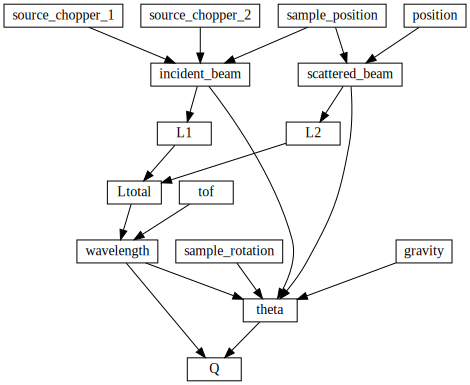

In [10]:
graph = amor.conversions.specular_reflection()
sc.show_graph(graph, simplified=True)

## Computing the wavelength

To compute the wavelength of the neutrons,
we request the `wavelength` coordinate from the `transform_coords` method by supplying our graph defined above
(see [here](https://scipp.github.io/scippneutron/user-guide/coordinate-transformations.html)
for more information about using `transform_coords`).

We also exclude all neutrons with a wavelength lower than 2.4 &#8491;.

In [11]:
sample_wav = sample.transform_coords(["wavelength"], graph=graph)
wavelength_edges = sc.array(dims=['wavelength'], values=[2.4, 16.0], unit='angstrom')
sample_wav = sc.bin(sample_wav, edges=[wavelength_edges])
sample_wav.attrs['orso'].value.data_source.measurement.instrument_settings.wavelength = fileio.base.ValueRange(
    wavelength_edges.min().value, wavelength_edges.max().value, 'angstrom')
sample_wav

<scipp.DataArray>
Dimensions: Sizes[detector_id:9216, wavelength:1, ]
Coordinates:
  beam_size                 float64             [mm]  ()  [2]
  detector_id                 int32           [None]  (detector_id)  [1, 2, ..., 9215, 9216]
  detector_spatial_resolution  float64              [m]  ()  [0.0025]
  gravity                   vector3          [m/s^2]  ()  [(0, -9.80665, 0)]
  sample_rotation           float64            [deg]  ()  [0.7989]
  sample_size               float64             [mm]  ()  [10]
  sample_size_resolution    float64  [dimensionless]  (detector_id)  [0.000436211, 0.000436211, ..., 0.00045, 0.00045]
  sigma_lambda_by_lambda    float64  [dimensionless]  (detector_id)  [0.126423, 0.126423, ..., 0.127288, 0.127288]
  source_position           vector3              [m]  ()  [(0, 0, 30)]
  wavelength                float64             [Å]  (wavelength [bin-edge])  [2.4, 16]
Data:
                          DataArrayView           [None]  (detector_id, wavelength)  [<scipp.DataArray>
Dimensions: Sizes[event:0, ]
Coordinates:
  pulse_time              datetime64             [ns]  (event)  []
  wavelength                float64             [Å]  (event)  []
Data:
                            float32         [counts]  (event)  []  []
Attributes:
  tof                       float64            [µs]  (event)  []

, <scipp.DataArray>
Dimensions: Sizes[event:0, ]
Coordinates:
  pulse_time              datetime64             [ns]  (event)  []
  wavelength                float64             [Å]  (event)  []
Data:
                            float32         [counts]  (event)  []  []
Attributes:
  tof                       float64            [µs]  (event)  []

, ..., <scipp.DataArray>
Dimensions: Sizes[event:0, ]
Coordinates:
  pulse_time              datetime64             [ns]  (event)  []
  wavelength                float64             [Å]  (event)  []
Data:
                            float32         [counts]  (event)  []  []
Attributes:
  tof                       float64            [µs]  (event)  []

, <scipp.DataArray>
Dimensions: Sizes[event:0, ]
Coordinates:
  pulse_time              datetime64             [ns]  (event)  []
  wavelength                float64             [Å]  (event)  []
Data:
                            float32         [counts]  (event)  []  []
Attributes:
  tof                       float64            [µs]  (event)  []

]
Attributes:
  L1                        float64              [m]  ()  [15]
  L2                        float64              [m]  (detector_id)  [4.12934, 4.12928, ..., 4.0007, 4.00076]
  Ltotal                    float64              [m]  (detector_id)  [19.1293, 19.1293, ..., 19.0007, 19.0008]
  base_position             vector3              [m]  (detector_id)  [(-0.064, 0.0945976, 4.12644), (-0.059871, 0.0945976, 4.12644), ..., (0.059871, 0, 4), (0.064, 0, 4)]
  com                     DataArray           [None]  ()  [<scipp.DataArray>
Dimensions: Sizes[time:1, dim_1:1, ]
Coordinates:
  alarm_severity             string           [None]  ()  ["NO_ALARM"]
  alarm_status               string           [None]  ()  ["NO_ALARM"]
  alarm_time                  int64             [ns]  ()  [1606316395427112960]
  time                    datetime64             [ns]  (time)  [2020-11-25T14:59:55.427112960]
Data:
                            float64           [None]  (time, dim_1)  [-1.599]

]
  coz                     DataArray           [None]  ()  [<scipp.DataArray>
Dimensions: Sizes[time:1, dim_1:1, ]
Coordinates:
  alarm_severity             string           [None]  ()  ["NO_ALARM"]
  alarm_status               string           [None]  ()  ["NO_ALARM"]
  alarm_time                  int64             [ns]  ()  [1606316397533574144]
  time                    datetime64             [ns]  (time)  [2020-11-25T14:59:57.533574144]
Data:
                            float64           [None]  (time, dim_1)  [114.52]

]
  experiment_title           string           [None]  ()  ["commissioning"

In [12]:
sample_wav.bins.concatenate('detector_id').plot()

In [13]:
reference_wav = reference.transform_coords(["wavelength"], graph=graph)
reference_wav = sc.bin(reference_wav, edges=[wavelength_edges])
reference_wav.attrs['orso'].value.data_source.measurement.instrument_settings.wavelength = fileio.base.ValueRange(
    wavelength_edges.min().value, wavelength_edges.max().value, 'angstrom')

## Compute the angle and perform the footprint correction

Using the same method, we can compute the angle of reflectance ($\theta$) and therefore correct for the footprint of the beam. 

In [14]:
sample_theta = sample_wav.transform_coords(['theta'], graph=graph)
sample_theta.attrs['orso'].value.data_source.measurement.instrument_settings.incident_angle = fileio.base.ValueRange(
    sample_theta.coords['theta'].min().value, sample_theta.coords['theta'].max().value, 'rad')

The final part of the resolution to consider is that from the spatial resolution of the detector pixels, $\Delta z$, which depends on the angle of incidence. 

$$ \frac{\sigma_{\gamma}}{\theta} = \frac{1}{2\sqrt{2\ln{2}}} \arctan{\frac{\Delta z}{d_{\text{SD}}}}, $$

where, $d_{\text{SD}}$ is the same to detector distance. 

In [15]:
sample_theta.bins.coords['sigma_gamma_by_theta'] = amor.tools.fwhm_to_std(
    sc.atan(
            sample_theta.coords['detector_spatial_resolution'] / sample.coords['position'].fields.z)) / sample_theta.bins.coords['theta']

From the theta values, we can calculate the footprint of the beam on the sample.

In [16]:
beam_on_sample = sample_theta.coords['beam_size'] / sc.sin(sample_theta.bins.coords['theta'])

Then we can determine the footprint scaling factor for the given theta angle as follows. 

In [17]:
footprint_scale = sc.erf(amor.tools.fwhm_to_std(sample_theta.coords['sample_size'] / beam_on_sample))

This footprint scale factor accounts for the fact that the illuminated area of the sample depends on the angle of incidence (which as we noted previously may be different for the sample and the reference).

In [18]:
sample_theta /= footprint_scale.squeeze()
sample_theta.attrs['orso'].value.reduction.corrections += ['footprint correction']

Then we repeat this process for the reference.

In [19]:
reference_theta = reference_wav.transform_coords(['theta'], graph=graph)
reference_theta.attrs['orso'].value.data_source.measurement.instrument_settings.incident_angle = fileio.base.ValueRange(
    reference_theta.coords['theta'].min().value, reference_theta.coords['theta'].max().value, 'deg')
beam_on_sample = reference_theta.coords['beam_size'] / sc.sin(reference_theta.bins.coords['theta'])
footprint_scale = sc.erf(amor.tools.fwhm_to_std(reference_theta.coords['sample_size'] / beam_on_sample))
reference_theta /= footprint_scale.squeeze()
reference_theta.attrs['orso'].value.reduction.corrections += ['footprint correction']

## Compute the Q vector

Once again using the same method, we can compute the $Q$ vector,
which now depends on both detector position (id) and wavelength

In [20]:
sample_q = sample_theta.transform_coords(["Q"], graph=graph)
sample_q.attrs['orso'].value.reduction.corrections += ['gravity correction']
reference_q = reference_theta.transform_coords(["Q"], graph=graph)
reference_q.attrs['orso'].value.reduction.corrections += ['gravity correction']
q_edges = sc.geomspace(dim='Q', start=0.008, stop=0.08, num=201, unit='1/angstrom')
sample_q_binned = sc.bin(sample_q, edges=[q_edges])
reference_q_binned = sc.bin(reference_q, edges=[q_edges])
sc.plot({'sample': sample_q_binned.sum('detector_id'), 'uncalibrated reference': reference_q_binned.sum('detector_id')}, norm="log")

## Calibration of the super-mirror

In order to normalise the data to give reflectivity data, as mentioned above, we use a measurement from a neutron super-mirror. 
However, first we must calibrate the super-mirror measurement. 
The calibration of the super-mirror depends on the properties of the super-mirror, and follows the equation below, 

$$ n(q) = 
  \begin{cases}
    1, & \text{where } q < c_{\mathrm{sm}} \\
    [1-\alpha(q - c_{\mathrm{sm}})]^{-1}, & \text{where } c_{\mathrm{sm}} \leq q \leq mc_{\mathrm{sm}} \\
    0, & \text{where } q > mc_{\mathrm{sm}},
  \end{cases}  
$$

where $\alpha$, $m$, and $c_{\mathrm{sm}}$ are super-mirror properties. 

The number of counts in each of the detector/$Q$ bins are then summed and the calibration factor is found and the two are divided. 

In [21]:
reference_q_summed = reference_q_binned.bins.sum()
calibration_factor = amor.calibrations.supermirror_calibration(reference_q_summed.coords['Q'])
reference_q_summed_cal = reference_q_summed * calibration_factor
reference_q_summed_cal.attrs['orso'].value.reduction.corrections += ['supermirror calibration']

The effect on the reference measurement can be seen in the plot below. 

In [22]:
sc.plot({'Uncalibrated': reference_q_summed.sum('detector_id'), 
         'Calibrated': reference_q_summed_cal.sum('detector_id')}, 
        norm='log')

## Normalization by the super-mirror

For each of the measurements, we should determine the number of counts in each bins and normalise this by the total number of counts in the measurement.

In [23]:
sample_q_summed = sample_q_binned.bins.sum()
sample_q_summed.coords['sigma_gamma_by_theta'] = sample_q_binned.bins.coords['sigma_gamma_by_theta'].max('detector_id')

sample_ncounts = sample_q_summed.sum()
sample_norm = sample_q_summed / sample_ncounts
sample_norm.attrs['orso'].value.reduction.corrections += ['total counts']
reference_ncounts = reference_q_summed_cal.sum()
reference_norm = reference_q_summed_cal / reference_ncounts
reference_norm.attrs['orso'].value.reduction.corrections += ['total counts']

Now, we should obtain the final normalised data by dividing the two datasets. 

In [24]:
normalized = sample_norm / reference_norm
normalized.attrs['orso'] = sample_norm.attrs['orso']
normalized.attrs['orso'].value.reduction.corrections = list(
    set(sample_norm.attrs['orso'].value.reduction.corrections + reference_norm.attrs['orso'].value.reduction.corrections))
normalized.attrs['orso'].value.data_source.measurement.reference = reference_norm.attrs['orso'].value.data_source.measurement.data_files

The plot below shows the reflecivity as a function of `'detector_id'` and `'Q'`.
Here, we note that there are a large number of pixels, where there was no neutrons detected in the reference measurements, leading to values of `nan` and `inf` in the normalised data.
Therefore, we should mask these pixels before finding the mean along the `'detector_id'` dimension. 

In [25]:
sc.plot(normalized, resolution={'y': 1000, 'x': 201}, norm='log')

The reference is assumed to be a perfect scatterer, therefore where there is no reflectivity in the reference measurement is it taken to be a region of `'Q'` space that cannot be accessed by the instrument. 
This leads to the number of detectors feeding data into each $Q$-bin being variable, this is particularly noticable at low-$Q$, there there are only a few pixels detecting neutrons. 
Therefore, in order to account for this variability as a function of $Q$, we mask those pixels where no neutrons were detected and perform an average over the remaining `'detector_id'` to reduce the data. 

In [26]:
normalized.masks['no_reference_neutrons'] = (reference_norm == sc.scalar(0)).data
sc.plot(normalized.mean('detector_id'), norm='log')

To obtain the final resolution as a function of $Q$, the three components of the resolution function are combined. 

In [27]:
normalized.coords['sigma_Q_by_Q'] = sc.sqrt(
    normalized.coords['sigma_gamma_by_theta'] ** 2 + \
    normalized.coords['sigma_lambda_by_lambda'] ** 2 + \
    normalized.coords['sample_size_resolution'] ** 2)

## Writing to a file

Having completed the data reduction process, it is then possible to write the data to a `.ort` format file. 
This [file format](https://github.com/reflectivity/file_format/blob/master/specification.md) has been developed for reduction reflectometry data by [ORSO](https://www.reflectometry.org). 

In [28]:
reflectometry.save(normalized, 'amor.ort')

This file will be rich in metadata that has been included during the reduction process. 

In [29]:
!head amor.ort

# # ORSO reflectivity data file | 0.1 standard | YAML encoding | https://www.reflectometry.org/
# data_source:
#   owner:
#     name: Jochen Stahn
#     affiliation: Paul Scherrer Institut
#     contact: jochen.stahn@psi.ch
#   experiment:
#     title: commissioning
#     instrument: AMOR
#     start_date: '2020-11-25'


## Make a $(\lambda, \theta)$ map

A good sanity check is to create a two-dimensional map of the counts in $\lambda$ and $\theta$ bins.
To achieve this, we request two output coordinates from the `transform_coords` method.

In [30]:
sample_theta = sample.transform_coords(["theta", "wavelength"], graph=graph)

Then, we concatenate all the events in the `detector_id` dimension

In [31]:
sample_theta = sample_theta.bins.concatenate('detector_id')

Finally, we bin into the existing `theta` dimension, and into a new `wavelength` dimension,
to create a 2D output

In [32]:
nbins = 165
theta_edges = sc.linspace(dim='theta', start=0.0, stop=1.2, num=nbins, unit='deg')
wavelength_edges = sc.linspace(dim='wavelength', start=0, stop=15.0, num=nbins, unit='angstrom')
binned = sc.bin(sample_theta, edges=[sc.to_unit(theta_edges, 'rad'), wavelength_edges])
binned

<scipp.DataArray>
Dimensions: Sizes[theta:164, wavelength:164, ]
Coordinates:
  beam_size                 float64             [mm]  ()  [2]
  detector_spatial_resolution  float64              [m]  ()  [0.0025]
  sample_size               float64             [mm]  ()  [10]
  source_position           vector3              [m]  ()  [(0, 0, 30)]
  theta                     float64            [rad]  (theta [bin-edge])  [0, 0.000127707, ..., 0.0208162, 0.020944]
  wavelength                float64             [Å]  (wavelength [bin-edge])  [0, 0.0914634, ..., 14.9085, 15]
Data:
                          DataArrayView           [None]  (theta, wavelength)  [<scipp.DataArray>
Dimensions: Sizes[event:0, ]
Coordinates:
  pulse_time              datetime64             [ns]  (event)  []
  theta                     float64            [rad]  (event)  []
  wavelength                float64             [Å]  (event)  []
Data:
                            float32         [counts]  (event)  []  []
Attributes:
  tof                       float64            [µs]  (event)  []

, <scipp.DataArray>
Dimensions: Sizes[event:0, ]
Coordinates:
  pulse_time              datetime64             [ns]  (event)  []
  theta                     float64            [rad]  (event)  []
  wavelength                float64             [Å]  (event)  []
Data:
                            float32         [counts]  (event)  []  []
Attributes:
  tof                       float64            [µs]  (event)  []

, ..., <scipp.DataArray>
Dimensions: Sizes[event:0, ]
Coordinates:
  pulse_time              datetime64             [ns]  (event)  []
  theta                     float64            [rad]  (event)  []
  wavelength                float64             [Å]  (event)  []
Data:
                            float32         [counts]  (event)  []  []
Attributes:
  tof                       float64            [µs]  (event)  []

, <scipp.DataArray>
Dimensions: Sizes[event:0, ]
Coordinates:
  pulse_time              datetime64             [ns]  (event)  []
  theta                     float64            [rad]  (event)  []
  wavelength                float64             [Å]  (event)  []
Data:
                            float32         [counts]  (event)  []  []
Attributes:
  tof                       float64            [µs]  (event)  []

]
Attributes:
  L1                        float64              [m]  ()  [15]
  com                     DataArray           [None]  ()  [<scipp.DataArray>
Dimensions: Sizes[time:1, dim_1:1, ]
Coordinates:
  alarm_severity             string           [None]  ()  ["NO_ALARM"]
  alarm_status               string           [None]  ()  ["NO_ALARM"]
  alarm_time                  int64             [ns]  ()  [1606316395427112960]
  time                    datetime64             [ns]  (time)  [2020-11-25T14:59:55.427112960]
Data:
                            float64           [None]  (time, dim_1)  [-1.599]

]
  coz                     DataArray           [None]  ()  [<scipp.DataArray>
Dimensions: Sizes[time:1, dim_1:1, ]
Coordinates:
  alarm_severity             string           [None]  ()  ["NO_ALARM"]
  alarm_status               string           [None]  ()  ["NO_ALARM"]
  alarm_time                  int64             [ns]  ()  [1606316397533574144]
  time                    datetime64             [ns]  (time)  [2020-11-25T14:59:57.533574144]
Data:
                            float64           [None]  (time, dim_1)  [114.52]

]
  experiment_title           string           [None]  ()  ["commissioning"]
  gravity                   vector3          [m/s^2]  ()  [(0, -9.80665, 0)]
  horizontal              DataArray           [None]  ()  [<scipp.DataArray>
Dimensions: Sizes[time:0, dim_1:1, ]
Coordinates:
  alarm_severity             string           [None]  (time)  []
  alarm_status               string           [None]  (time)  []
  alarm_time                  int64             [ns]  (time)  []
  cue_index                   int32           [None]  (time)  []
  cu

In [33]:
binned.bins.sum().plot()

This plot can be used to check if the value of the sample rotation angle $\omega$ is correct.
The bright triangles should be pointing back to the origin $\lambda = \theta = 0$.

## References

<div id='stahn2016'></div>
Stahn J., Glavic A., **2016**,
*Focusing neutron reflectometry: Implementation and experience on the TOF-reflectometer Amor*,
[Nuclear Instruments and Methods in Physics Research Section A: Accelerators, Spectrometers, Detectors and Associated Equipment, 821, 44-54](https://doi.org/10.1016/j.nima.2016.03.007)